In [91]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

import rasterio
from rasterio.io import MemoryFile
from rasterio.transform import Affine

plt.rcParams['text.usetex'] = True

In [88]:
def centerline_2_points(geom, dx=30):
    # https://stackoverflow.com/questions/34906124/interpolating-every-x-distance-along-multiline-in-shapely
    num_vert = int(round(geom.length / dx))
    if num_vert == 0: 
        num_vert = 1
    multipoint = [geom.interpolate(float(n)/num_vert,normalized=True) for n in range(num_vert + 1)] 
    Latx = [multipoint[i].x for i in range(len(multipoint))]
    Laty = [multipoint[i].y for i in range(len(multipoint))]
    gdf  = gpd.GeoDataFrame(geometry=gpd.points_from_xy(Latx,Laty))
    return gdf


In [2]:
surface = np.loadtxt('../Data/SurfTopo.dat')[:,1]
bedprof = np.loadtxt('../Data/BedTopo.dat' )[:,1]
x_coord = np.loadtxt('../Data/BedTopo.dat' )[:,0]

In [3]:
MB     = np.load('../Data/surgio_withdeb_NMB.npy')
MB     = np.mean(MB,axis=0)
masked = np.ma.masked_array(MB, np.isnan(MB))

XX = np.load('../Data/surgio_Xs.npy')
YY = np.load('../Data/surgio_Ys.npy')
ZZ = np.load('../Data/surgio_Zs.npy')

In [89]:
FL_dir = '/Users/andrewnolan/sfuvault/LilKluane/flowlines/'
FL1_fp = os.path.join(FL_dir,'manual/surge_trib/surge_trib.shp')
FL2_fp = os.path.join(FL_dir,'manual/main/Little_Kluan_FL_main.shp')

# Read the centerline for Little Kluane
LK_FL  = gpd.read_file(FL2_fp)

# Conver the centerline to points with spacing dx
LK_CP  = centerline_2_points(LK_FL,dx=100)
LK_CP['UTM_N'] = None
LK_CP['UTM_E'] = None

for i,row in enumerate(LK_CP['geometry']):
    LK_CP.iloc[i,1] = row.y
    LK_CP.iloc[i,2] = row.x   
prof_coords = [(x,y) for x, y in zip(LK_CP.UTM_E, LK_CP.UTM_N)]

In [97]:
xres      = XX[0,1] - XX[0,0] 
yres      = YY[1,0] - YY[0,0] 
transform = Affine.translation(XX.min(), YY.max()) * Affine.scale(xres, -yres)

# Dictionary of projection related params for georefrencings
kwags = { 'driver'    :'GTiff', 
          'height'    : MB.shape[0], 
          'width'     : MB.shape[1], 
          'count'     : 1, 
          'dtype'     : MB.dtype, 
          'crs'       : '+proj=utm +zone=7 +datum=WGS84 +units=m +no_defs', 
          'transform' : transform
        }

# Write the data to temp file 
with MemoryFile() as memfile:
    kwags['dtype'] = 'float64'
    with memfile.open(**kwags) as src:
        src.write(MB.data,1)
        LK_CP['bdot'] = [x for x in src.sample(prof_coords)]
        LK_CP['bdot'] = LK_CP.apply(lambda x: x['bdot'][0], axis=1)

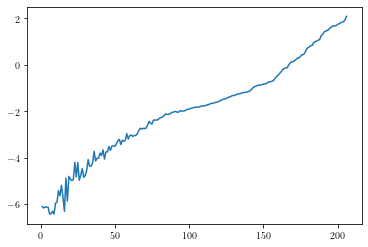

In [99]:
plt.plot(LK_CP['bdot'])

Text(0.5, 1.0, 'Yearly Mean')

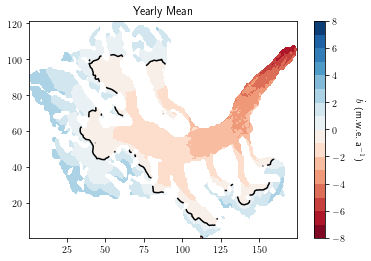

In [6]:
fig, ax = plt.subplots(1,1)

ax.contour(masked,levels=[0],origin='upper',colors='k')
img  = ax.contourf(masked,levels=np.linspace(-8,8,17),cmap='RdBu',origin='upper')
cbar = fig.colorbar(img)
cbar.set_label('$\dot b$   (m.w.e. a$^{-1}$)',rotation=270,labelpad=20)
ax.set_title('Yearly Mean')

# Modeled Mass Balance 

$$
T(t,z) = \alpha \sin\left( \frac{2\pi t}{365} \right) + T_{\rm ma} + z \frac{\partial T}{\partial z}
$$

It's possible and pretty easy to do this calculation with array broadcasting, but since we are proto-typing code for `Fortran` lets write this with a `for` loop to make the translation easier. 

In [7]:
t    = np.arange(1,366)     # [J]       Julian Calendar Days
dTdz = -6.5*1e-4            # [K m^-1]  Atmospheric Lapse Rate
T_ma = 276.15               # [K]       Mean Annual Temp at ref. elev of z=0
α    = 20.0                 # [K]       Seasonal Variability
m, n = (x_coord.shape[0],t.shape[0])
T    = np.zeros((m,n))

In [8]:
for i,day in enumerate(t): 
    T[:,i] = α*np.sin((2*np.pi*day)/365.)+T_ma+surface*dTdz

In [9]:
yearinsec = 365.25*24.*60.*60                 # [s a^-1]
f_dd   = 4.0                                  # [mm K-1 d-1] degree day factor for snow
f_dd   = f_dd * 1e-3 * 365.                   # [m K-1 a-1]  degree day factor for snow
rho_w  = 1000.0*1.0E-06*(yearinsec)**(-2.0)   # [kg m-3] ---> [MPa a2 m-2]    water density 
L_f    = 334000.0*yearinsec**2                # [J kg-1] --> [m2 a-2] latent heat of fusion
h_aq   = 3.0                                  # [m]     firn aquifer thickness
r      = 0.5                                  # [ ]     runoff fraction 
T_plus = T.mean(axis=1)                       # [K] positive yearly-averaged daily-maximum air temp.

In [10]:
Q_m = (1-r)*(rho_w/h_aq)*f_dd*L_f*np.abs(np.min((273.15 - T_plus, np.zeros_like(T_plus)),axis=0))

In [11]:
Q_m[surface < 2000] = 0.

(9000.0, 31500.0)

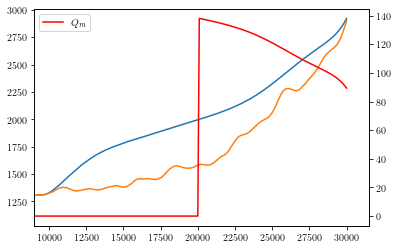

In [12]:
fig, ax0 = plt.subplots()
ax1 = ax0.twinx()
ax0.plot(x_coord, surface)
ax0.plot(x_coord, bedprof)
ax1.plot(x_coord, Q_m,'r',label=r'$Q_m$')
ax1.legend(loc=2)
ax0.set_xlim(9000,None)

# Units

In [13]:
import pint 
import numpy as np 
import matplotlib.pyplot as plt 
ureg = pint.UnitRegistry()

ModuleNotFoundError: No module named 'pint'

In [ ]:
a   = ureg.year             # [a]
d   = ureg.day              # [d]
s   = ureg.sec              # [s]
K   = ureg.K                # [K]
J   = ureg.joule            # [J]
m   = ureg.meter            # [m]
mm  = ureg.millimeter       # [mm]
W   = ureg.watt             # [W]
kg  = ureg.kilogram         # [kg]
MPa = ureg('MPa')           # [MPa]

In [ ]:
spy   = 365.25*24*60*60 * (s/a)                    # [s a^-1]
T_ref = 200.0           * (K)                      # [K]
CapA  = 7.253           * (J*kg**-1*K**-2)         # [J kg-1 K-2]
CapB  = 146.3           * (J*kg**-1*K**-1)         # [J kg-1 K-1]
EFlux = 0.20            * (W*m**-2)                # [W m^-2]
L_f   = 334000.0        * (J*kg**-1)               # [J kg-1]

ρ_i   = 910             * (kg*m**-3)               # [Kg m^-3]
ρ_w   = 1000.           * (kg*m**-3)               # [Kg m^-3]
g     = 9.81            * (m*s**-2)                # [m s^-2]
h_aq  = 3.0             * (m)                      # [m]
f_dd  = 4.0             * (mm*(K*d)**-1)           # [mm K^-1 d^-1]

In [ ]:
ρ_i  = ρ_i* (MPa/MPa.to_base_units()) * spy**-2 # Ice Density in Elmer base units
ρ_w  = ρ_w* (MPa/MPa.to_base_units()) * spy**-2 # Water Density in Elmer base units
h_aq = h_aq                                     # Firn aquifer thickness in Elmer base units
f_dd = f_dd*365*(d/a)*1e-3*(m/mm)               # Degree Day factor for snow in Elmer base units
L_f  = L_f * spy**2                             # Latent heat of fusion  in Elmer base units
T_s  = (T[-1,-1] - 273.15) * K                  # Nodal surface temperature in Elmer base units

In [ ]:
((1-r)*(rho_w/h_aq)*f_dd*L_f*T_s)#.to_compact(m**2 / a**2)

In [ ]:
(1*J).units

In [ ]:
(1500 * spy**2) * T_s